In [144]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

(5771, 27)
(722, 27)
(5771, 8) (5771,)
(722, 8) (722,)
Number of parameters: 2722
Epoch 1/100, Loss: 0.6869, Val Loss: 0.6802, Accuracy: 0.5997
Epoch 2/100, Loss: 0.6754, Val Loss: 0.6590, Accuracy: 0.6482
Epoch 3/100, Loss: 0.6356, Val Loss: 0.6417, Accuracy: 0.6593
Epoch 4/100, Loss: 0.6014, Val Loss: 0.6281, Accuracy: 0.6648
Epoch 5/100, Loss: 0.5590, Val Loss: 0.6198, Accuracy: 0.6676
Epoch 6/100, Loss: 0.8145, Val Loss: 0.6139, Accuracy: 0.6704
Epoch 7/100, Loss: 0.5478, Val Loss: 0.6101, Accuracy: 0.6745
Epoch 8/100, Loss: 0.6895, Val Loss: 0.6073, Accuracy: 0.6717
Epoch 9/100, Loss: 0.5128, Val Loss: 0.6066, Accuracy: 0.6704
Epoch 10/100, Loss: 0.5902, Val Loss: 0.6060, Accuracy: 0.6704
Epoch 11/100, Loss: 0.7434, Val Loss: 0.6057, Accuracy: 0.6704
Epoch 12/100, Loss: 0.7694, Val Loss: 0.6053, Accuracy: 0.6690
Epoch 13/100, Loss: 0.7355, Val Loss: 0.6053, Accuracy: 0.6690
Epoch 14/100, Loss: 0.4649, Val Loss: 0.6053, Accuracy: 0.6690
Epoch 15/100, Loss: 0.5730, Val Loss: 0.6053,

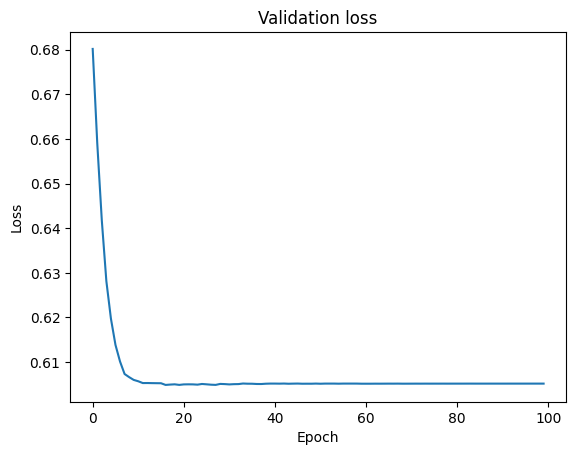

In [271]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn.functional as F


# Load dataset

df_train_path = os.path.join(DATA_FOLDER, 'train_dataset.csv')
df_train = pd.read_csv(df_train_path)

df_dev_path = os.path.join(DATA_FOLDER, 'dev_dataset.csv')
df_dev = pd.read_csv(df_dev_path)

print(df_train.shape)
print(df_dev.shape)


def feature_engineering(df):

    X = df[[ "age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree_F", "c_charge_degree_M", "days_b_screening_arrest"]]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled



X_train_scaled = feature_engineering(df_train)
X_dev_scaled = feature_engineering(df_dev)

# prepare targets for train and validation
y_train = (df_train["two_year_recid"])# * 10).clip(0,9)
y_dev = (df_dev["two_year_recid"])# * 10).clip(0,9)

print(X_train_scaled.shape, y_train.shape)
print(X_dev_scaled.shape, y_dev.shape)


# convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_dev_tensor = torch.tensor(X_dev_scaled, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev.values, dtype=torch.long)


N_INPUT = X_train_tensor.shape[1]
N_OUTPUT = 2


# define the model
model = nn.Sequential(
            nn.Linear(N_INPUT, 64),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            # nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, N_OUTPUT),
            # nn.Softmax(dim=1)
        )




parameters = [p for p in model.parameters()]

# for parameter in parameters:
#     parameter.requires_grad = True

print("Number of parameters:", sum(p.nelement() for p in parameters))

epochs = 100
batch_size = 64

number_of_samples = X_train_tensor.size(0)  

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


loses = []  

for epoch in range(epochs):
    
    model.train()
    
    # Shuffle the data at the start of each epoch
    indices = torch.randperm(number_of_samples)
    X_train_shuffled = X_train_tensor[indices]
    y_train_shuffled = y_train_tensor[indices]
    
    # Loop through mini-batches
    for i in range(0, number_of_samples, batch_size):
        # Get the mini-batch
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        # print(y_batch.shape)
        
        # forward pass
        outputs = model(X_batch)
        # outputs = outputs.argmax(dim=1)
        
        # print(outputs.shape)


        loss = criterion(outputs, y_batch)
                
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        for name, param in model.named_parameters():
            if param.grad is None:
                print(f"Parameter {name} has no gradient!")
                
                
        for name, param in model.named_parameters():
            if param.grad is not None:
                # print(f"Layer: {name}, Grad Norm: {param.grad.norm()}")
                pass
            else:
                print(f"Layer: {name} has no gradient!")

        
    scheduler.step()


    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_dev_tensor)
        val_loss = criterion(val_outputs, y_dev_tensor)
        loses.append(val_loss.item())
        
        # CALCULATE ACCURACY
        val_outputs = val_outputs.argmax(dim=1)
        correct = (val_outputs == y_dev_tensor).sum().item()
        total = y_dev_tensor.size(0)
        accuracy = correct / total
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Accuracy: {accuracy:.4f}")





plt.plot(loses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation loss")
plt.show()


In [253]:
print(df_train["two_year_recid"].value_counts())
print(df_train.describe())

two_year_recid
0    3175
1    2596
Name: count, dtype: int64
               age  juv_misd_count  juv_fel_count  juv_other_count  \
count  5771.000000     5771.000000    5771.000000      5771.000000   
mean     34.601282        0.090279       0.063767         0.112459   
std      11.791322        0.478654       0.464052         0.519968   
min      18.000000        0.000000       0.000000         0.000000   
25%      25.000000        0.000000       0.000000         0.000000   
50%      31.000000        0.000000       0.000000         0.000000   
75%      42.000000        0.000000       0.000000         0.000000   
max      96.000000       12.000000      20.000000        17.000000   

       priors_count  days_b_screening_arrest  two_year_recid  decile_score  \
count   5771.000000              5771.000000     5771.000000   5771.000000   
mean       3.452088                 3.864079        0.449835      4.523479   
std        4.855690                75.731015        0.497520      2.837957